In [1]:
a=2

In [2]:
import numpy as np
import numba
import scipy.sparse as ssp
import scipy.stats
import time
import sys
import pdb
from functools import partial
# %load_ext line_profiler
%load_ext autoreload
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

## NUMBA EXPERIMENTS

In [1]:
from QH_ED import landau
from QH_ED import utils
from QH_ED import hilbert
from QH_ED import observables
from functools import partial

In [3]:
Nphi = 24
Ne = 8
Nth = 4 # numer of threads for parallelization
torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
vParams = {'power': (1.0, {'n': 0, 'x': 4})} # Coulomb power law, Gaussian cut-off
hamParams = {'alpha': 1.0, 'n': 1, 'Nphi': Nphi} # mass anisotropy, Landau level index

In [4]:
pot1 = landau.Potential(torus=torus1, vParams=vParams, hamParams=hamParams)
pot1.setV2()
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

hilb = [None]*Ne
hilbLen = [None]*Ne
dictx = [None]*Ne

for sector in range(Ne):
    hilb[sector], hilbLen[sector] = utils.Utils.getHilb(Nphi, Ne, sector)
    dictx[sector] = hilbert.getDict(hilb[sector])

In [5]:
## test if matvec is the same as mat
E_all = [None]*Ne
V_all = [None]*Ne

# E_all_shell = [None]*Ne
# V_all_shell = [None]*Ne

for sector in range(Ne):
    NH = len(hilb[sector])
    dij = hilbert.getMatAux(Nphi, Ne, NH, hilb[sector], hilbLen[sector], T4, dictx[sector], Nth)
    HMat = hilbert.dijToCsr(dij, NH)
    E_all[sector], V_all[sector] = scipy.sparse.linalg.eigsh(HMat, k=16, which='SA')
    
#     newMatVec = partial(hilbert.getMatVec, Nphi=Nphi, Ne=Ne, NH=NH, hilb=hilb[sector], 
#                         hilbLen=hilbLen[sector], T4=T4, dictx=dictx[sector])
#     HA = ssp.linalg.LinearOperator((NH, NH), matvec=newMatVec)
    
#     E_all_shell[sector], V_all_shell[sector] = scipy.sparse.linalg.eigsh(HA, k=6, which='SA')

In [6]:
E_all#, E_all_shell

[array([-0.91051965, -0.90973493, -0.90922881, -0.90625965, -0.90625965,
        -0.90286312, -0.90285185, -0.90285185, -0.90029662, -0.9002285 ,
        -0.9002285 , -0.89901381, -0.89901381, -0.89698329, -0.89459765,
        -0.89459765]),
 array([-0.906828  , -0.906828  , -0.9048478 , -0.9048478 , -0.90287495,
        -0.90106559, -0.90106559, -0.9002285 , -0.90014247, -0.89641521,
        -0.89641521, -0.89636171, -0.89636171, -0.89545295, -0.89545295,
        -0.89386795]),
 array([-0.90954592, -0.90625965, -0.90580641, -0.90580641, -0.90306048,
        -0.90285185, -0.90266662, -0.90266662, -0.90149637, -0.90149637,
        -0.90106559, -0.90106559, -0.89969674, -0.89857187, -0.89857187,
        -0.89636171]),
 array([-0.906828  , -0.906828  , -0.90436703, -0.90266662, -0.90266662,
        -0.90085375, -0.90085375, -0.89901381, -0.89859   , -0.89857187,
        -0.89857187, -0.89641521, -0.89641521, -0.89634143, -0.89634143,
        -0.89525852]),
 array([-0.91995457, -0.91270572

In [7]:
(E_all[0][0])/Ne

-0.11381495632932992

In [8]:
np.sum((pot1.V2))

(0.23408183057230375-7.837314966011835e-33j)

## SPEED TESTS

In [24]:
t1 = time.time()
Nphi = 24
Ne = 8
sector = 4
Nth = 4

torus1 = landau.Torus(Nphi, aspect_ratio=1.0)
hamParams = {'alpha': 1.0, 'n': 0, 'Nphi': Nphi} # mass anisotropy, Landau level index
vParams = {'power': (1.0, {'n': 1, 'x': np.inf})} # Coulomb power law, Gaussian cut-off
vParams = {'haldane': (1.0, {'Vm': [0, 1]})} # Haldane pseudopotential

pot1 = landau.Potential(torus=torus1, vParams=vParams, hamParams=hamParams)
pot1.setV2()
T4 = np.real(utils.Utils.make4tensorsym(torus1, pot1.V2))

hilb_s, hilbLen_s = utils.Utils.getHilb(Nphi, Ne, sector)
dictx = hilbert.getDict(hilb_s)
NH = len(hilb_s)
###########
t2 = time.time()

dij = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, T4, dictx, Nth)
t2b = time.time()
HMat = hilbert.dijToCsr(dij, NH)
###########
t3 = time.time()
newMatVec = partial(hilbert.getMatVec, Nphi=Nphi, Ne=Ne, NH=len(hilb_s), hilb=hilb_s, 
                    hilbLen=hilbLen_s, T4=T4, dictx=dictx)
HA = ssp.linalg.LinearOperator((NH, NH), matvec=newMatVec)
###########
t4 = time.time()
npOnes = np.ones(sum(hilbLen_s))

In [25]:
# hilbert.getMatAux.parallel_diagnostics(level=2)

In [11]:
print(t2 - t1)
print(t2b - t2)
print(t3 - t2b)
print(t4 - t3)

0.015341758728027344
3.6743004322052
0.43463683128356934
0.607053279876709


In [12]:
t1 = time.time()
v1 = HMat.dot(npOnes)
t2 = time.time()
v2 = newMatVec(npOnes)
t3 = time.time()
print(t3 - t2)
print(t2 - t1)

0.602269172668457
0.006325960159301758


In [13]:
np.max(np.abs(v1-v2))

2.4424906541753444e-15

In [14]:
t1 = time.time()
Exx, Vxx = ssp.linalg.eigsh(HMat, k=6, which='SA')
t2 = time.time()
# Eyy, Vyy = ssp.linalg.eigsh(HA, k=6, which='SA')
t3 = time.time()
print(t2 - t1)
print(t3 - t2)

2.326512098312378
4.1961669921875e-05


In [15]:
Exx

array([-2.02014901, -1.95465458, -1.95465458, -1.93826526, -1.93780827,
       -1.93780827])

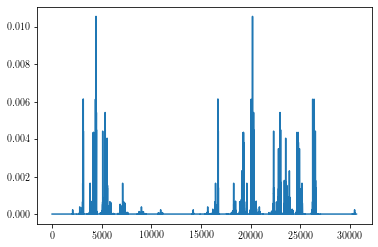

In [16]:
f, ax = plt.subplots()
ax.plot(Vxx[:, 0]**2)

In [17]:
Vxx[23675, 0]**2

0.00019442206311937805

In [18]:
CDWx = np.array([ 0,  3,  6,  9, 12, 15, 18, 21])+2

In [19]:
dictx[np.sum(2**CDWx)]

23675

## Expectation values

In [20]:
hilbObj1 = hilbert.Hilbert(Nphi=Nphi, Ne=Ne, NH=NH, hilb=hilb_s, hilbLen=hilbLen_s, dictx=dictx)

In [21]:
obs1 = observables.Observables(torus1, hamParams, hilbObj1)

In [22]:
nX = 30
x_diag = 0.5 * np.arange(nX+1) * torus1.Lx / nX
r_arr = np.c_[x_diag, x_diag]
gRdiag = obs1.gr(r_arr, Vxx[:, 0])


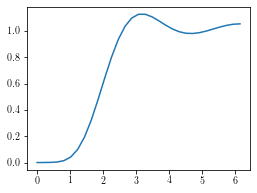

In [23]:
f, ax = plt.subplots(figsize=(4,3))
ax.plot(x_diag, gRdiag)

In [266]:
nX = 10
nY = 10
t1 = time.time()
gR1 = obs1.grAux(nX, nY, Vxx[:, 0])
t2 = time.time()
print(t2 - t1)

80.87156295776367


In [267]:
torus1.Lx, torus1.Ly

(12.279920495357862, 12.279920495357862)

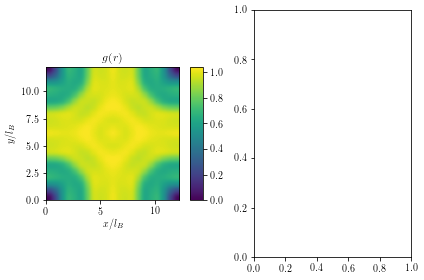

In [268]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
interp = 'gaussian'

f, (ax, bx) = plt.subplots(1, 2, figsize=(6, 4))
im1 = ax.imshow(gR1.T, interpolation=interp, extent=[0, torus1.Lx, 0, torus1.Ly])

ax.set_xlabel(r'$x / l_B$')
ax.set_ylabel(r'$y / l_B$')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="10%", pad=0.15)
ax.set_title(r'$g(r)$')

# poop = Sk + Sk[:, ::-1]
# im2 = bx.imshow(np.abs(poop.T), interpolation=interp, extent=[kx[0], kx[-1], ky[0], ky[-1]])
# bx.set_xlabel(r'$k_x$')
# bx.set_ylabel(r'$k_y$')
# divider = make_axes_locatable(bx)
# cbx = divider.append_axes("right", size="10%", pad=0.15)
# bx.set_title(r'$S(k)$')

# bx.plot(np.sqrt(torus1.Lx**2 + torus1.Ly**2) * np.arange(gR1.shape[0])/(gR1.shape[0] - 1),
#         np.diag(gR1))
# bx.set_xlim(0, np.sqrt(torus1.Lx**2 + torus1.Ly**2)/2)
# bx.set_ylim(0)
# bx.set_xlabel(r'$r/l_B$')
# bx.set_ylabel(r'$g(r)$')

f.colorbar(im1, cax=cax)
f.colorbar(im2, cax=cbx)
f.tight_layout()
# f.savefig('/home/ak20/QH/plots/grSk_Nphi24_Ne8_ar1.pdf')

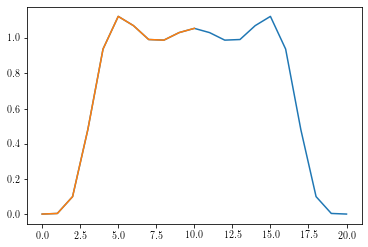

In [183]:
plt.plot(np.diag(gR1))


In [136]:
x_arr = 0.5 * np.arange(2*nX+1) * torus1.Lx / nX
y_arr = 0.5 * np.arange(2*nY+1) * torus1.Ly / nY
kx, ky, _ = torus1.get_karr()

In [135]:
gR1.shape

(41, 41)

In [137]:
r_grid = np.meshgrid(x_arr, y_arr)

In [138]:
r_grid[0].shape

(41, 41)

In [139]:
x_grid = r_grid[0].T
y_grid = r_grid[1].T

In [141]:
def expK(kx_val, ky_val):
    return np.exp(1j*kx_val*x_grid) * np.exp(1j*ky_val*y_grid)

In [72]:
fofxy = expK(kx[10], ky[10]) * gR1

In [140]:
rho0 = 1/(2*np.pi*3)
kx = np.r_[-4:4:31j]
ky = np.r_[-4:4:31j]

In [95]:
kx

array([-4.        , -3.73333333, -3.46666667, -3.2       , -2.93333333,
       -2.66666667, -2.4       , -2.13333333, -1.86666667, -1.6       ,
       -1.33333333, -1.06666667, -0.8       , -0.53333333, -0.26666667,
        0.        ,  0.26666667,  0.53333333,  0.8       ,  1.06666667,
        1.33333333,  1.6       ,  1.86666667,  2.13333333,  2.4       ,
        2.66666667,  2.93333333,  3.2       ,  3.46666667,  3.73333333,
        4.        ])

In [110]:
poop = Sk[13:18, 13:18]
poop[2,2] = 0
np.abs(poop + poop[::-1, :])/2

array([[0.97402294, 0.94632414, 0.93440095, 0.94632414, 0.97402294],
       [0.86286514, 0.54832764, 0.33355991, 0.54832764, 0.86286514],
       [0.9173966 , 0.50385709, 0.        , 0.50385709, 0.9173966 ],
       [0.86286514, 0.54832764, 0.33355991, 0.54832764, 0.86286514],
       [0.97402294, 0.94632414, 0.93440095, 0.94632414, 0.97402294]])

In [142]:
Sk = np.zeros((len(kx), len(ky)), dtype='complex128')
for ckx, kxval in enumerate(kx):
    for cky, kyval in enumerate(ky):
        fofxy = expK(kxval, kyval) * (gR1 - 1)
        
        Sk[ckx, cky] = 1 + rho0 *scipy.integrate.simps(np.array([scipy.integrate.simps(
                        fofxy[:, i], x_arr) for i in range(2*nY+1)]), y_arr)

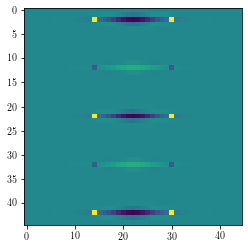

In [88]:
plt.imshow(np.real((Sk[60:105, 60:105])))

In [67]:
np.sin(np.r_[0:np.pi:101j])

array([0.00000000e+00, 3.14107591e-02, 6.27905195e-02, 9.41083133e-02,
       1.25333234e-01, 1.56434465e-01, 1.87381315e-01, 2.18143241e-01,
       2.48689887e-01, 2.78991106e-01, 3.09016994e-01, 3.38737920e-01,
       3.68124553e-01, 3.97147891e-01, 4.25779292e-01, 4.53990500e-01,
       4.81753674e-01, 5.09041416e-01, 5.35826795e-01, 5.62083378e-01,
       5.87785252e-01, 6.12907054e-01, 6.37423990e-01, 6.61311865e-01,
       6.84547106e-01, 7.07106781e-01, 7.28968627e-01, 7.50111070e-01,
       7.70513243e-01, 7.90155012e-01, 8.09016994e-01, 8.27080574e-01,
       8.44327926e-01, 8.60742027e-01, 8.76306680e-01, 8.91006524e-01,
       9.04827052e-01, 9.17754626e-01, 9.29776486e-01, 9.40880769e-01,
       9.51056516e-01, 9.60293686e-01, 9.68583161e-01, 9.75916762e-01,
       9.82287251e-01, 9.87688341e-01, 9.92114701e-01, 9.95561965e-01,
       9.98026728e-01, 9.99506560e-01, 1.00000000e+00, 9.99506560e-01,
       9.98026728e-01, 9.95561965e-01, 9.92114701e-01, 9.87688341e-01,
      

In [70]:
scipy.integrate.simps(np.sin(np.r_[0:np.pi:101j]), np.r_[0:np.pi:101j])

2.000000010824504

In [ ]:
kx, ky

In [35]:
%lprun -f obs1.gr obs1.gr(2, 2, Vxx[:, 0])

Timer unit: 1e-06 s

Total time: 2.78016 s
File: /home/ak20/QH/QH_ED/QH_ED/observables.py
Function: gr at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                               def gr(self, nX, nY, V):
    25                                                   """
    26                                                   pair correlation function
    27                                                   
    28                                                   inputs:
    29                                                   ---------
    30                                                   nX  : int, number of points along x-direction of torus
    31                                                   nY  : int, number of points along y-direction of torus
    32                                                   V   : np.array, eigenvector
    33                                                   
    34                                     

In [21]:
## TESting
kx, ky, mmax = torus1.get_karr()
vDeltaParams = {'delta': (1.0, {'x0': 0.35, 'y0': 0.42})}
VkFF = landau.Potential.applyFF(kx, ky, 
                 landau.Potential.getVk(kx, ky, vDeltaParams), 
                 hamParams)


T4_delta = utils.Utils.make4tensorsym(torus1, VkFF)

In [23]:
newMatVec = partial(hilbert.getMatVecC, 
                    Nphi = hilbObj1.Nphi, 
                    Ne = hilbObj1.Ne, 
                    NH = hilbObj1.NH, 
                    hilb = hilbObj1.hilb, 
                    hilbLen = hilbObj1.hilbLen, 
                    T4 = T4_delta,
                    dictx = hilbObj1.dictx)

elem = np.inner(Vxx[:, 0]*(1.0+0.0j), newMatVec(Vxx[:, 0]*(1.0+0.0j)))

In [24]:
elem

(-0.0008774110654936184+0.05785219113906988j)

In [21]:
## check if stuff is ok
dijX1, dijX2 = hilbert.getMatAuxC(Nphi, Ne, NH, hilb_s, hilbLen_s, T4_delta, dictx, Nth)

In [22]:
HX = scipy.sparse.coo_matrix((NH, NH))
for i in np.arange(4):
    HX += scipy.sparse.coo_matrix((dijX2[i, :], 
                                 (dijX1[i, 0, :], dijX1[i, 1, :])),
                                 shape=(NH, NH))

HX = HX.tocsr()

In [25]:
np.inner(Vxx[:, 0], HX.dot(Vxx[:, 0]))

(0.006201058250996212+6.179952383167375e-18j)

In [23]:
np.max(np.abs(HX - HX.conj().T))

3.947085571718001e-17

In [23]:
EX, VX = np.linalg.eig(HX.todense())

In [26]:
Earg = np.argsort(np.real(EX))

In [30]:
EX = EX[Earg]

In [32]:
VX = VX[:, Earg]

In [35]:
VX[:, 0].T.dot(Vxx[:, 0])

matrix([[-1.+0.j]])

In [30]:
VX[:, 0].dot(Vxx[:,0])

ValueError: shapes (1038,1) and (1038,) not aligned: 1 (dim 1) != 1038 (dim 0)

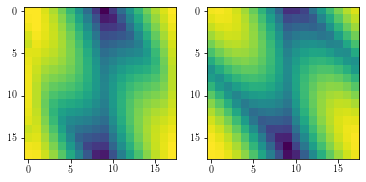

In [21]:
f, (ax, bx) = plt.subplots(1, 2)
ax.imshow(np.log10(np.abs(np.roll(T4, [0], axis=0))))
bx.imshow(np.log10(np.abs(T4_delta)))

In [37]:
T4_delta[:4, :4]

array([[ 0.02275289+5.22418517e-19j,  0.02406358+1.61404269e-02j,
         0.00696524+1.69853239e-02j, -0.00115903+5.66938888e-03j],
       [ 0.01058398+6.69709665e-20j,  0.01586974+1.06444868e-02j,
         0.00651243+1.58811123e-02j, -0.00153638+7.51520278e-03j],
       [ 0.00347267-1.30147539e-19j,  0.00738214+4.95150322e-03j,
         0.0042949 +1.04734708e-02j, -0.0014365 +7.02664135e-03j],
       [ 0.00080368-5.66404160e-19j,  0.00242213+1.62462088e-03j,
         0.00199786+4.87195160e-03j, -0.00094736+4.63401567e-03j]])

In [38]:
np.max(np.abs(np.imag(HMat)))

0.0

In [39]:
np.max(np.abs(HMat - HMat.conj().T))

1.3877787807814457e-16

In [40]:
dij_delta_R = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, np.real(T4_delta), dictx, Nth)
Mat_delta_R = hilbert.dijToCsr(dij_delta_R, NH)
dij_delta_I = hilbert.getMatAux(Nphi, Ne, NH, hilb_s, hilbLen_s, np.imag(T4_delta), dictx, Nth)
Mat_delta_I = hilbert.dijToCsr(dij_delta_I, NH)

In [41]:
Mat_delta_R[:4, :4].todense()

matrix([[-2.19171203e-02,  6.01144164e-05,  4.64565463e-04,
          1.20897018e-03],
        [ 1.90349883e-05, -1.10433078e-02,  1.59667079e-03,
          1.68808407e-03],
        [ 4.63040405e-05,  5.53253020e-04, -7.86701605e-03,
         -4.09029967e-03],
        [ 2.95998680e-05,  2.96295669e-04,  4.24268909e-04,
         -1.78062804e-02]])

In [22]:
MM = Mat_delta_R + 1.0j*Mat_delta_I

In [36]:
np.dot(Vxx[:, 0], Mat_delta.dot(Vxx[:, 0]))

-2.0201490136484326

In [23]:
np.max(np.abs(MM - MM.conj().T))

0.3184701421146091

In [58]:
@numba.njit(numba.float64[:](numba.float64[:]))
def doSomethingf(x):
    return 2.0*x

@numba.njit(numba.complex128[:](numba.complex128[:]))
def doSomethingc(x):
    return 3.0*x

In [59]:
xIn1 = np.random.randn(10)
xOut1 = doSomethingf(xIn1)
xIn2 = np.random.randn(10)*1.0j
xOut2 = doSomethingc(xIn2)

In [60]:
xIn1, xOut1, xIn2, xOut2

(array([ 2.24222802,  1.24183604,  2.44193996, -0.90800834, -0.17920522,
         1.36881542, -0.40600028,  0.31186499, -0.54783695,  0.15567293]),
 array([ 4.48445604,  2.48367209,  4.88387991, -1.81601668, -0.35841045,
         2.73763084, -0.81200057,  0.62372999, -1.09567391,  0.31134585]),
 array([ 0.+1.03350948j, -0.-0.76714511j, -0.-0.02830501j, -0.-1.10897831j,
         0.+0.38259845j,  0.+1.01406919j,  0.+1.14085992j, -0.-1.83264951j,
         0.+0.62863811j,  0.+0.42554809j]),
 array([0.+3.10052843j, 0.-2.30143532j, 0.-0.08491502j, 0.-3.32693494j,
        0.+1.14779536j, 0.+3.04220756j, 0.+3.42257977j, 0.-5.49794853j,
        0.+1.88591434j, 0.+1.27664427j]))

In [20]:
# %lprun -f scipy.sparse.linalg.eigsh scipy.sparse.linalg.eigsh(HA, k=6, which='SA')

(0, 2.5)

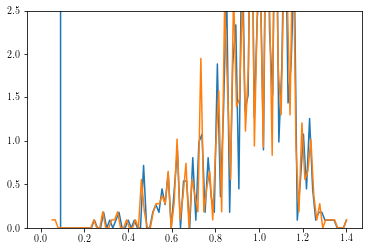

In [21]:
h, b = np.histogram((np.abs(HMat.data)), bins=100)
h2, b2 = np.histogram(np.abs(HMat.diagonal()), bins = 100)
f, ax = plt.subplots()
ax.plot(0.5*(b[1:]+b[:-1]), h/(np.sum(h)*(b[1]-b[0])) / HMat.shape[0] * HMat.size)
ax.plot(0.5*(b2[1:]+b2[:-1]), h2/(np.sum(h2)*(b2[1]-b2[0])))
ax.set_ylim(0, 2.5)

In [41]:
@numba.njit(numba.types.ListType(numba.int64)(numba.int64), 
            parallel=True, fastmath=True)
def getThu(Nphi):
    l = numba.typed.List()
    for i in numba.prange(Nphi):
        l.append(i+10)#np.zeros(10, dtype=numba.int64))
    return l

In [44]:
p = getThu(10)

In [45]:
p

ListType[int64]([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [33]:
run runSim.py 0 0 8 /tigress/ak20/QH/anisoMayCoulomb/ 0

0.0027780532836914062
0.5485620498657227
204.40676975250244


In [44]:
ls -lah /tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi27_Ne9_sector0_alpha10_E.npy

-rw-r--r-- 1 ak20 ee 176 May 25 17:59 /tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi27_Ne9_sector0_alpha10_E.npy


In [45]:
poop = np.load('/tigress/ak20/QH/anisoMayCoulomb/LL0/ar000/Nphi27_Ne9_sector0_alpha10_E.npy')

In [46]:
poop

array([-2.35406978, -2.29561763, -2.29561763, -2.26946669, -2.26946669,
       -2.25893621])

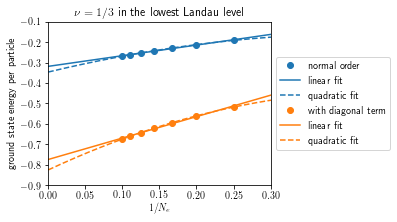

In [69]:
Ne_arr = np.array([4, 5, 6, 7, 8, 9, 10])
E0_1_3 = np.array([-0.190605, -0.211767, -0.228524, -0.241565, -0.252519, -0.261563, -0.269021])
Vq_sum = np.array([0.6543087, 0.6995266, 0.7332350, 0.7596026, 0.7809539, 0.798699, 0.8137518])
X = np.r_[0.001:0.35:0.001]
func = lambda x, a, b, c: a*x*x + b*x + c

f, ax = plt.subplots(figsize=(4, 3))
ax.plot(1/Ne_arr, E0_1_3, 'o', label=r'normal order')
sl, ic, _, _, _ = scipy.stats.linregress(1/Ne_arr, E0_1_3)
ax.plot(X, sl*X + ic, color='C0', ls='-', label='linear fit')
popt, pcov = scipy.optimize.curve_fit(func, 1/Ne_arr, E0_1_3)
ax.plot(X, func(X, *popt), color='C0', ls='--', label='quadratic fit')

ax.plot(1/Ne_arr, E0_1_3-0.5*Vq_sum, 'o',
        label=r'with diagonal term')
sl, ic, _, _, _ = scipy.stats.linregress(1/Ne_arr, E0_1_3-0.5*Vq_sum)
ax.plot(X, sl*X + ic, color='C1', ls='-', label='linear fit')
popt, pcov = scipy.optimize.curve_fit(func, 1/Ne_arr, E0_1_3-0.5*Vq_sum)
ax.plot(X, func(X, *popt), color='C1', ls='--', label='quadratic fit')

# ax.plot(1/Ne_arr, 2/np.pi*E0_1_3 - Vq_sum/(2*np.pi), 'o')
# sl, ic, _, _, _ = scipy.stats.linregress(1/Ne_arr, 2/np.pi*E0_1_3 - Vq_sum/(2*np.pi))
# ax.plot(X, sl*X + ic, '-')
# popt, pcov = scipy.optimize.curve_fit(func, 1/Ne_arr, 2/np.pi*E0_1_3 - Vq_sum/(2*np.pi))
# ax.plot(X, func(X, *popt))

ax.set_xlim(0, 0.30)
ax.set_ylim(-0.9, -0.1)
ax.set_xlabel(r'$1/N_e$')
ax.set_ylabel(r'ground state energy per particle')
ax.legend(loc='center left', bbox_to_anchor=[1.00,0.50])
ax.set_title(r'$\nu = 1/3$ in the lowest Landau level')
# f.tight_layout()
f.savefig('/home/ak20/QH/plots/nu_1_3_energies.pdf', bbox_inches='tight', transparent=True)

In [45]:
func(X, *popt)[0]/2

-0.4130008287308483

In [18]:
alp_arr = np.r_[1.0:4.01:0.1] # 31
asp_arr = np.array([0, 0.25, 0.5])
Ne_arr = np.array([6, 7, 8, 9, 10])

E0 = np.zeros((2, len(Ne_arr), len(asp_arr), len(alp_arr), 10, 6)) * np.nan
cf = 0
fol = '/tigress/ak20/QH/anisoMayCoulomb/'

for LL in [0, 1]:
    for cNe, Ne in enumerate(Ne_arr):
        Nphi = 3*Ne
        for casp, ar_factor in enumerate(asp_arr):
            for calp, alpha in enumerate(alp_arr):

                for sector in range(Ne):
                    try:
                        fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}'.format(
                               Nphi, Ne, sector, int(round(10*alpha)))
                        dat = np.load(fol+'LL{0:d}/ar{1:03d}/'.format(
                                LL, int(round(100*ar_factor)))+fil+'_E.npy')
                        E0[LL, cNe, casp, calp, sector, :] = dat
                    except FileNotFoundError:
                        pass

(-0.28, -0.13)

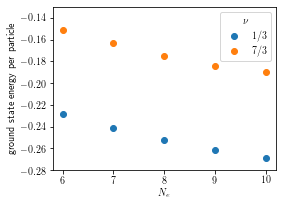

In [18]:
f, ax = plt.subplots(figsize=(4, 3))
ax.plot(Ne_arr, np.nanmin(E0[0, :, 0, 0, :, 0], axis=1)/Ne_arr, 'o', label=r'$1/3$')
ax.plot(Ne_arr, np.nanmin(E0[1, :, 0, 0, :, 0], axis=1)/Ne_arr, 'o', label=r'$7/3$')
ax.legend(loc='upper right', title=r'$\nu$')
ax.set_xlabel(r'$N_e$')
ax.set_ylabel(r'ground state energy per particle')
ax.set_ylim(-0.28, -0.13)
# f.savefig('/home/ak20/QH/plots/nu_1_3.pdf', bbox_inches='tight', transparent=True)

In [56]:
for i in range(5):
    temp = np.sort((E0[1, i, 0, 0, :, :]).flatten())
    print(temp[1]-temp[0])

0.002174334727458982
0.004406740968040168
0.010409334537381465
0.014498432053128951
0.005479884919186606


In [37]:
np.sort(np.nanmin(E0[0, :, 0, 0, :, 0], axis=1))

array([-2.69021372, -2.35406978, -2.02014901, -1.69095466, -1.3711444 ])

(-0.28, -0.13)

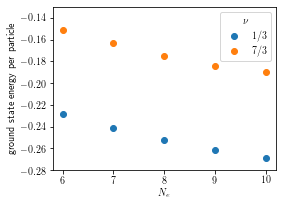

In [19]:
f, ax = plt.subplots(figsize=(4, 3))
ax.plot(Ne_arr, np.nanmin(E0[0, :, 0, 0, :, 0], axis=1)/Ne_arr, 'o', label=r'$1/3$')
ax.plot(Ne_arr, np.nanmin(E0[1, :, 0, 0, :, 0], axis=1)/Ne_arr, 'o', label=r'$7/3$')
ax.legend(loc='upper right', title=r'$\nu$')
ax.set_xlabel(r'$N_e$')
ax.set_ylabel(r'ground state energy per particle')
ax.set_ylim(-0.28, -0.13)
# f.savefig('/home/ak20/QH/plots/nu_1_3.pdf', bbox_inches='tight', transparent=True)

In [20]:
np.nanmin(E0[1, :, 0, 0, :, 0], axis=1)/Ne_arr

array([-0.15129619, -0.16280329, -0.17488675, -0.18432131, -0.18996998])

In [24]:
E0[1, 4, 0, 0, :, :] - np.min(E0[1, 4, 0, 0, :, :])

array([[0.01334966, 0.01380972, 0.01380972, 0.01473751, 0.01685826,
        0.01927478],
       [0.0151394 , 0.0151394 , 0.01784952, 0.02002861, 0.02002861,
        0.0207794 ],
       [0.01284481, 0.01284481, 0.01865181, 0.01927478, 0.01986352,
        0.01986352],
       [0.01100711, 0.01100711, 0.01380972, 0.0151394 , 0.0151394 ,
        0.01940723],
       [0.01161358, 0.01284481, 0.01284481, 0.01940723, 0.01940723,
        0.0207794 ],
       [0.        , 0.00547988, 0.01161358, 0.01161358, 0.01473751,
        0.01784952],
       [0.01161358, 0.01284481, 0.01284481, 0.01940723, 0.01940723,
        0.0207794 ],
       [0.01100711, 0.01100711, 0.01380972, 0.0151394 , 0.0151394 ,
        0.01940723],
       [0.01284481, 0.01284481, 0.01865181, 0.01927478, 0.01986352,
        0.01986352],
       [0.0151394 , 0.0151394 , 0.01784952, 0.02002861, 0.02002861,
        0.0207794 ]])

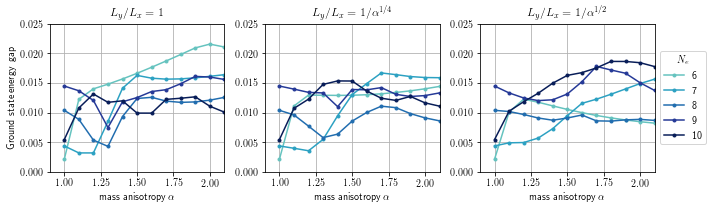

In [53]:
f, axs = plt.subplots(1, 3, figsize=(10, 3))
ylims = [[0.040, 0.065], [0, 0.025]]
LL = 1
spl_title = ['1', r'1/\alpha^{1/4}', r'1/\alpha^{1/2}']
for casp, ar_factor in enumerate(asp_arr):
    for cNe, Ne in enumerate(Ne_arr):
        E_Ne_ar = E0[LL, cNe, casp, :, :, :]
        E_Ne_ar = E_Ne_ar.reshape(31, 60)
        E_Ne_ar = np.sort(E_Ne_ar)
        axs[casp].plot(alp_arr, E_Ne_ar[:, 1] - E_Ne_ar[:, 0], 
                label=str(Ne), marker='.', color=plt.cm.YlGnBu((Ne-3)/7))


    axs[casp].set_xlabel(r'mass anisotropy $\alpha$')
    if casp == 0: axs[casp].set_ylabel(r'Ground state energy gap')
    axs[casp].set_xlim(0.9, 2.1)
    axs[casp].set_ylim(ylims[LL])
    if casp == 2: axs[casp].legend(loc='center left', title=r'$N_e$', 
                                      bbox_to_anchor=(1.00, 0.50))
    axs[casp].set_title(r'$ L_y / L_x = '+spl_title[casp]+'$')
    axs[casp].grid(True)

f.tight_layout()
f.savefig('/home/ak20/QH/plots/anisoMay_LL1.pdf', bbox_inches='tight', transparent=True)

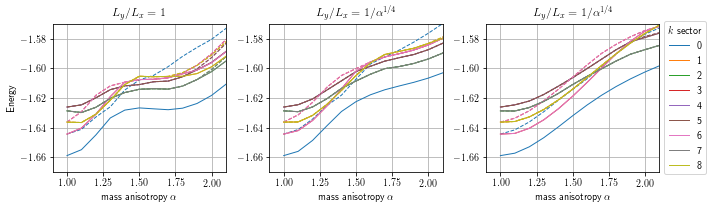

In [67]:
f, axs = plt.subplots(1, 3, figsize=(10, 3))
# ylims = [[-2.70, -2.35], [-1.91, -1.81]]
ylims = [[-2.40, -2.05], [-1.67, -1.57]]
# ms = ['.', 'x', '+']
ls = ['-', '--', ':']

LL = 1
Ne = 9
cNe = Ne - 6
spl_title = ['1', r'1/\alpha^{1/4}', r'1/\alpha^{1/4}']
for casp, ar_factor in enumerate(asp_arr):
    for sector in range(Ne):
        for Ex in range(2):
            E_Ne_ar = E0[LL, cNe, casp, :, sector, :]
            labx = str(sector) if Ex == 0 else '_nolegend_'
            axs[casp].plot(alp_arr, E_Ne_ar[:, Ex], label=labx,
                           ls=ls[Ex], lw = 1, color='C{0:d}'.format(sector))
        
    axs[casp].set_xlabel(r'mass anisotropy $\alpha$')
    if casp == 0: axs[casp].set_ylabel(r'Energy')
    axs[casp].set_xlim(0.9, 2.1)
    axs[casp].set_ylim(ylims[LL])
    if casp == 2: axs[casp].legend(loc='center left', title=r'$k$ sector', 
                                      bbox_to_anchor=(1.00, 0.50))
    axs[casp].set_title(r'$ L_y / L_x = '+spl_title[casp]+'$')
    axs[casp].grid(True)
f.tight_layout()
f.savefig('/home/ak20/QH/plots/anisoMay_E_Ne9_LL1.pdf', bbox_inches='tight', transparent=True)

In [20]:
E0 = np.zeros((len(Ne_arr), len(asp_arr), len(alp_arr), 8, 6)) * np.nan
for cNe, Ne in enumerate(Ne_arr[:]):
    Nphi = 3*Ne
    for casp, aspect_ratio in enumerate(asp_arr):
        for calp, alpha in enumerate(alp_arr):
            
            E_all = np.zeros(0)
            
            for sector in range(Ne):
                fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}_ar{4:d}'.format(
                       Nphi, Ne, sector, int(round(10*alpha)), int(round(100*aspect_ratio)))
                try:
                    E0[cNe, casp, calp, sector, :] = np.load(fol+fil+'_E.npy')
                    cf += 1
#                     E_all = np.r_[E_all, dat]
                except FileNotFoundError:
                    pass
                
#             E_all.sort()
#             E0[cNe, casp, calp] = E_all[1] - E_all[0]

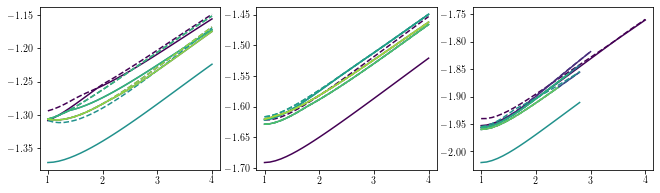

In [334]:
f, (ax, bx, cx) = plt.subplots(1, 3, figsize=(11, 3))

for sector in np.arange(7):
    ax.plot(alp_arr, E0[0, 1, :, sector, 0], color=plt.cm.viridis(sector/6))
    ax.plot(alp_arr, E0[0, 1, :, sector, 1], color=plt.cm.viridis(sector/6), ls='--')
    
    bx.plot(alp_arr, E0[1, 1, :, sector, 0], color=plt.cm.viridis(sector/7))
    bx.plot(alp_arr, E0[1, 1, :, sector, 1], color=plt.cm.viridis(sector/7), ls='--')
    
    cx.plot(alp_arr, E0[2, 1, :, sector, 0], color=plt.cm.viridis(sector/8))
    cx.plot(alp_arr, E0[2, 1, :, sector, 1], color=plt.cm.viridis(sector/8), ls='--')

In [40]:
def myfun(x, C, S):
    lC = len(C)
    lS = len(S)
    return np.sum(C*np.cos(2*np.pi*np.outer(x, np.arange(lC))) + \
                  S*np.cos(2*np.pi*np.outer(x, np.arange(lS))), axis=1)

C = np.random.randn(5)
S = np.random.randn(5)

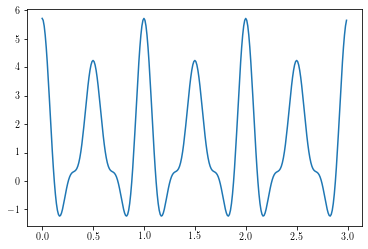

In [41]:
f, ax = plt.subplots()
ax.plot(np.r_[0:3:0.01], myfun(np.r_[0:3:0.01], C, S))

In [30]:
fol = '/tigress/ak20/QH/anisoMayCoulomb/LL1/ar000/'
Ne_arr = np.array([9, 10, 11, 12, 13, 14])

E0 = np.nan*np.zeros((6, 14, 6))
for cNe, Ne in enumerate(Ne_arr):
    Nphi = 2*Ne
    for sector in range(Ne):
        fil = 'Nphi{0:d}_Ne{1:d}_sector{2:d}_alpha{3:d}'.format(
               Nphi, Ne, sector, int(round(10*1.0)))
        dat = np.load(fol+fil+'_E.npy')
        E0[cNe, sector, :] = dat

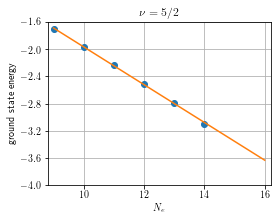

In [43]:
f, ax = plt.subplots(figsize=(4, 3))
Y = np.nanmin(E0[:,:,0], axis=1)
sl, ic, _, _, _ = scipy.stats.linregress(Ne_arr, Y)
ax.plot(Ne_arr, Y, 'o')
X = np.r_[Ne_arr, 16]
ax.plot(X, sl*X+ic)

ax.set_ylabel('ground state energy')
ax.set_xlabel('$N_e$')
ax.set_xlim(8.8, 16.2)
ax.set_ylim(-4.0, -1.6)
ax.set_yticks(np.r_[-4.0:-1.59:0.4])
ax.set_title(r'$\nu = 5/2$')
ax.grid(True)
f.savefig('/home/ak20/QH/plots/anisoMay_p5_q2_GS.pdf', bbox_inches='tight')

In [42]:
scipy.integrate.quad(myfun, 0, 1, (C, S))

(1.3831067735688094, 4.852275595212951e-10)

In [50]:
S*2*np.pi

array([ 9.86175363, -3.70501496,  7.41178403, -1.30339297,  3.9221096 ])

In [10]:
@numba.njit(numba.float64[:,:](numba.int64))
def test_diag(N):
    Mat = np.random.randn(N, N)
    Mat += Mat.T
    E, V = np.linalg.eigh(Mat)
    return V

@numba.njit(numba.float64[:,:,:](numba.int64, numba.int64),
            parallel=True)
def test_diag_aux(N, Nth):
    ret = np.zeros((Nth, N, N), dtype=numba.float64)
    for i in numba.prange(Nth):
        ret[i, :, :] = test_diag(N)
        
    return ret

@numba.njit(numba.float64[:,:,:](numba.int64, numba.int64),
            parallel=True)
def test_diag_two(N, Nth):
    ret = np.zeros((Nth, N, N), dtype=numba.float64)
    Mat = np.random.randn(N, N)
    Mat += Mat.T
    for i in numba.prange(Nth):
        E, V = np.linalg.eigh(Mat)
        ret[i, :, :] = V
        
    return ret

In [9]:
Nth = 4
t1 = time.time()
V_all = test_diag_aux(2048, Nth)
t2 = time.time()
V_all2 = test_diag_two(2048, Nth)
t3 = time.time()
print(t2 - t1)
print(t3 - t2)

8.709798574447632
10.243133544921875


In [13]:
M = np.random.randn(2, 3, 3)

In [15]:
M, M.T.shape

(array([[[-0.6656352 , -2.05013466,  1.153949  ],
         [ 1.12616358,  0.89243956,  0.19042904],
         [ 1.29691861, -0.00839807,  0.26937057]],
 
        [[-0.62397744, -0.31114466,  0.32390485],
         [-1.7387822 ,  0.22246765,  0.63007098],
         [-0.16898641,  0.4238755 ,  0.20389965]]]), (3, 3, 2))

In [ ]:
gogopo = np.random.rand(2, 3, 5)

In [49]:
len(gogopo)

2

In [40]:
NH = 337
Nth = 24
for i in range(Nth):
    print(np.arange((i*NH)//Nth, ((i+1)*NH)//Nth))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[14 15 16 17 18 19 20 21 22 23 24 25 26 27]
[28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[42 43 44 45 46 47 48 49 50 51 52 53 54 55]
[56 57 58 59 60 61 62 63 64 65 66 67 68 69]
[70 71 72 73 74 75 76 77 78 79 80 81 82 83]
[84 85 86 87 88 89 90 91 92 93 94 95 96 97]
[ 98  99 100 101 102 103 104 105 106 107 108 109 110 111]
[112 113 114 115 116 117 118 119 120 121 122 123 124 125]
[126 127 128 129 130 131 132 133 134 135 136 137 138 139]
[140 141 142 143 144 145 146 147 148 149 150 151 152 153]
[154 155 156 157 158 159 160 161 162 163 164 165 166 167]
[168 169 170 171 172 173 174 175 176 177 178 179 180 181]
[182 183 184 185 186 187 188 189 190 191 192 193 194 195]
[196 197 198 199 200 201 202 203 204 205 206 207 208 209]
[210 211 212 213 214 215 216 217 218 219 220 221 222 223]
[224 225 226 227 228 229 230 231 232 233 234 235 236 237]
[238 239 240 241 242 243 244 245 246 247 248 249 250 251]
[252 253 254 255 256 257 258 259 260 261 262 263 264 2